In [ ]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import RBF
from sklearn.kernel_ridge import KernelRidge
from scipy.integrate import simps

# 加载Lalonde数据集
data = pd.read_csv('LaLonde.csv')
X = data['treat'].values  # 处理变量
Y = data['re78'].values   # 结果变量 (1978年收入)
W = data['re75'].values   # 负控制结果 (1975年收入)

上述代码定义了两个高斯核函数（也称为径向基函数，RBF），高斯核函数是一种常用的核函数，其数学公式如下：

### 高斯核函数的数学公式
对于两个样本向量 $\mathbf{x}_i$ 和 $\mathbf{x}_j$，高斯核函数（RBF）的定义为：
$K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2}\right)$

其中：
- $\|\mathbf{x}_i - \mathbf{x}_j\|$ 是样本向量 $\mathbf{x}_i$ 和 $\mathbf{x}_j$ 之间的欧几里得距离。
- $\sigma$ 是核函数的带宽参数，它控制了核函数的宽度。

在代码中，`length_scale` 参数对应于 $\sigma$，并且代码中使用 `gamma` 来计算 `length_scale`，即 $\sigma = \frac{1}{\gamma}$。

### 代码中核函数的具体形式
在代码中，`kernel_W` 和 `kernel_X` 都是高斯核函数，它们的具体形式为：
$K_W(\mathbf{w}_i, \mathbf{w}_j) = \exp\left(-\frac{\|\mathbf{w}_i - \mathbf{w}_j\|^2}{2\sigma_W^2}\right)$
$K_X(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma_X^2}\right)$

其中，$\sigma_W = \sigma_X = \frac{1}{\text{gamma}} = 1.0$，因为代码中 `gamma = 1.0`。

总结来说，代码中定义的高斯核函数的数学形式为：
$K(\mathbf{a}, \mathbf{b}) = \exp\left(-\frac{\|\mathbf{a} - \mathbf{b}\|^2}{2}\right)$

这里的 $\mathbf{a}$ 和 $\mathbf{b}$ 分别对应于核函数 `kernel_W` 中的 $\mathbf{w}$ 和核函数 `kernel_X` 中的 $\mathbf{x}$。 

In [2]:
# 定义高斯核函数
gamma = 1.0
kernel_W = RBF(length_scale=1.0 / gamma)
kernel_X = RBF(length_scale=1.0 / gamma)


In [3]:
# 定义网格点，用于近似积分
t_values = np.linspace(-1, 1, 100)
s_values = np.linspace(-1, 1, 100)

In [4]:
# 估计 H_lambda(w, t) 函数
def estimate_H_lambda(t, W, Y):
    # 计算复数目标值
    phi_Y_t = np.exp(1j * t * Y)
    # 分解为实部和虚部
    phi_Y_t_real = np.real(phi_Y_t)
    phi_Y_t_imag = np.imag(phi_Y_t)
    # 创建两个 KernelRidge 模型
    kr_real = KernelRidge(kernel=kernel_W, alpha=1.0)
    kr_imag = KernelRidge(kernel=kernel_W, alpha=1.0)
    # 确保 W 是实数数组，并调整形状为 (n_samples, 1)
    W = np.real(W).reshape(-1, 1)
    # 分别拟合实部和虚部
    kr_real.fit(W, phi_Y_t_real)
    kr_imag.fit(W, phi_Y_t_imag)
    # 定义预测函数
    def H_lambda_predict(W_new):
        W_new = np.real(W_new).reshape(-1, 1)
        return kr_real.predict(W_new) + 1j * kr_imag.predict(W_new)
    
    return H_lambda_predict

In [5]:
# 计算 T_n(s, t)
def compute_T_n(s, t, H_lambda_predict, W, Y, X):
    # 确保输入是 numpy 数组
    W = np.asarray(W, dtype=np.float64)
    Y = np.asarray(Y)
    X = np.asarray(X)
    
    # 调整 W 形状为 (n_samples, 1)
    if W.ndim == 1:
        W = W.reshape(-1, 1)
    
    # 计算 U_hat
    Y_exp = np.exp(1j * t * Y)
    H_pred = H_lambda_predict(W).flatten()  # 确保形状匹配
    U_hat = Y_exp - H_pred
    
    # 计算 m_X_s
    m_X_s = np.exp(1j * s * X)
    
    # 计算 T_n
    T_n = np.sum(U_hat * m_X_s) / np.sqrt(len(X))
    return T_n

In [6]:
# 计算检验统计量 Delta_phi_m
def compute_Delta_phi_m(W, Y, X, t_values, s_values):
    max_integral = 0
    for t in t_values:
        H_lambda_predict = estimate_H_lambda(t, W, Y)
        integrals = []
        for s in s_values:
            T_n_s_t = compute_T_n(s, t, H_lambda_predict, W, Y, X)
            integrals.append(np.abs(T_n_s_t)**2)
        integral_value = simps(integrals, s_values)  # 使用Simpson方法计算积分
        if integral_value > max_integral:
            max_integral = integral_value
    return max_integral

In [7]:
# Bootstrap方法生成临界值并检验
def bootstrap_test(n_bootstrap=100):
    Delta_phi_m = compute_Delta_phi_m(W, Y, X, t_values, s_values)
    bootstrap_values = []
    for _ in range(n_bootstrap):
        # 生成Bootstrap样本
        indices = np.random.choice(len(X), len(X), replace=True)
        X_boot = X[indices]
        Y_boot = Y[indices]
        W_boot = W[indices]
        
        # 计算Bootstrap样本的 Delta_phi_m
        Delta_phi_m_boot = compute_Delta_phi_m(W_boot, Y_boot, X_boot, t_values, s_values)
        bootstrap_values.append(Delta_phi_m_boot)
    
    # 计算临界值（95%分位数，alpha=0.05）
    critical_value = np.percentile(bootstrap_values, 95)
    return Delta_phi_m, critical_value, Delta_phi_m > critical_value

# 执行检验并输出结果
if __name__ == "__main__":
    Delta_phi_m, critical_value, reject_H0 = bootstrap_test()
    print(f"检验统计量 Delta_{{phi, m}}: {Delta_phi_m:.4f}")
    #print("检验统计量 Delta_{phi, m}: {:.4f}".format(Delta_phi_m))
    print("临界值: {:.4f}".format(critical_value))
    if reject_H0:
        print("拒绝零假设 H_0，表明存在因果关系。")
    else:
        print("无法拒绝零假设 H_0，表明因果关系可能无法识别，存在非识别性问题。")

检验统计量 Delta_{phi, m}: 3.6408
临界值: 3.3980
拒绝零假设 H_0，表明存在因果关系。


In [8]:
import pandas as pd
# 加载数据集（使用 Stata 格式文件）
url = "http://users.nber.org/~rdehejia/data/nsw_dw.dta"
data = pd.read_stata(url)
# 查看数据前几行
print("数据集简介：")
print(data.info())
# 分离处理组和对照组
treat_group = data[data['treat'] == 1]
control_group = data[data['treat'] == 0]
# 计算处理组和对照组在 1978 年收入的平均值
mean_re78_treat = treat_group['re78'].mean()
mean_re78_control = control_group['re78'].mean()
# 计算收入差异
income_diff = mean_re78_treat - mean_re78_control
# 输出结果
print(f"\n处理组 1978 年平均收入: {mean_re78_treat:.2f}")
print(f"对照组 1978 年平均收入: {mean_re78_control:.2f}")
print(f"收入差异: {income_diff:.2f}")

数据集简介：
<class 'pandas.core.frame.DataFrame'>
Int64Index: 445 entries, 0 to 444
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   data_id    445 non-null    object 
 1   treat      445 non-null    float32
 2   age        445 non-null    float32
 3   education  445 non-null    float32
 4   black      445 non-null    float32
 5   hispanic   445 non-null    float32
 6   married    445 non-null    float32
 7   nodegree   445 non-null    float32
 8   re74       445 non-null    float32
 9   re75       445 non-null    float32
 10  re78       445 non-null    float32
dtypes: float32(10), object(1)
memory usage: 24.3+ KB
None

处理组 1978 年平均收入: 6349.15
对照组 1978 年平均收入: 4554.80
收入差异: 1794.35


In [9]:
csv_file_path = 'nsw_dw.csv'
data.to_csv(csv_file_path, index=False)

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 加载数据集
url = "http://users.nber.org/~rdehejia/data/nsw_dw.dta"
data = pd.read_stata(url)

# 选择场景 1 的变量
X = data['treat'].values
Y = data['re74'].values
W = data['education'].values

# 处理缺失值（删除缺失值）
data = data.dropna(subset=['treat', 're74', 'education'])
X = data['treat'].values
Y = data['re74'].values
W = data['education'].values

# 标准化 Y 和 W
scaler_Y = StandardScaler()
Y = scaler_Y.fit_transform(Y.reshape(-1, 1)).flatten()

scaler_W = StandardScaler()
W = scaler_W.fit_transform(W.reshape(-1, 1)).flatten()

In [11]:
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm

# 定义高斯核
kernel_W = RBF(length_scale=1.0)
kernel_X = RBF(length_scale=1.0)

# 计算 Gram 矩阵
K_W = kernel_W(W[:, None])
K_X = kernel_X(X[:, None])

# 估计 H(w, t)（简化示例）
H_est = np.linalg.pinv(K_W) @ Y

# 计算残差
residuals = Y - K_W @ H_est

# 计算测试统计量
test_stat = np.mean(residuals**2)

# 确定临界值（使用正态分布作为示例）
critical_value = norm.ppf(0.95)

# 判断是否拒绝 H0
reject_H0 = test_stat > critical_value

In [12]:

# Define the run_PMCR function
def run_PMCR(X, Y, W):
    """
    A simplified implementation of the PMCR method.
    
    Parameters:
    - X: Treatment variable (array)
    - Y: Outcome variable (array)
    - W: Covariate variable (array)
    
    Returns:
    - reject_H0: Boolean indicating whether to reject the null hypothesis
    """
    # Define Gaussian kernels
    kernel_W = RBF(length_scale=1.0)  # Kernel for covariate W
    kernel_X = RBF(length_scale=1.0)  # Kernel for treatment X
    
    # Compute Gram matrices
    K_W = kernel_W(W[:, None])  # Kernel matrix for W
    K_X = kernel_X(X[:, None])  # Kernel matrix for X (not used here, but included for completeness)
    
    # Estimate H(w, t) using pseudo-inverse (simplified)
    H_est = np.linalg.pinv(K_W) @ Y
    
    # Compute residuals
    residuals = Y - K_W @ H_est
    
    # Compute test statistic (mean squared residual)
    test_stat = np.mean(residuals**2)
    
    # Set critical value (using 95th percentile of standard normal as an example)
    critical_value = norm.ppf(0.95)
    
    # Decision: reject H0 if test_stat > critical_value
    reject_H0 = test_stat > critical_value
    return reject_H0



In [13]:
# 场景 1
X1 = data['treat'].values
Y1 = data['re74'].values
W1 = data['education'].values
# 运行 PMCR 方法（假设 run_PMCR 是已实现的函数）
reject_H0_scene1 = run_PMCR(X1, Y1, W1)
# Run the PMCR method for Scene 1
reject_H0_scene1 = run_PMCR(X1, Y1, W1)

# Print the result
print(f"Scene 1: Reject H0: {reject_H0_scene1}")
# 场景 2
X2 = data['treat'].values
Y2 = data['re78'].values
W2 = data['education'].values
# 运行 PMCR 方法
reject_H0_scene2 = run_PMCR(X2, Y2, W2)

# 输出结果
print(f"场景 1: 拒绝 H0: {reject_H0_scene1}")
print(f"场景 2: 拒绝 H0: {reject_H0_scene2}")

Scene 1: Reject H0: True
场景 1: 拒绝 H0: True
场景 2: 拒绝 H0: True


In [14]:
X2 = data['treat'].values
Y2 = data['re78'].values
W2 = data['education'].values
# Standardize Y2 and W2
scaler_Y2 = StandardScaler()
Y2 = scaler_Y2.fit_transform(Y2.reshape(-1, 1)).flatten()
scaler_W2 = StandardScaler()
W2 = scaler_W2.fit_transform(W2.reshape(-1, 1)).flatten()
# Run for Scene 2
reject_H0_scene2 = run_PMCR(X2, Y2, W2)
print(f"Scene 2: Reject H0: {reject_H0_scene2}")

Scene 2: Reject H0: False


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
def simple_test(data, alpha=0.05):
    """简单的 Z 检验，检验均值是否为 0"""
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    z_stat = mean / (std / np.sqrt(n))
    p_value = 2 * (1 - norm.cdf(np.abs(z_stat)))
    return p_value < alpha

In [16]:
def simulate_rates(n_samples, n_simulations=1000, effect_size=0.0):
    """模拟数据并计算 Type I Error Rate 或 Power Rate"""
    reject_count = 0
    for _ in range(n_simulations):
        # 生成正态分布数据
        data = np.random.normal(loc=effect_size, scale=1.0, size=n_samples)
        # 运行检验
        if simple_test(data):
            reject_count += 1
    return reject_count / n_simulations

# 参数设置
sample_sizes = [50, 100, 200, 500, 1000]  # 不同的样本量
alpha = 0.05  # 显著性水平

# 计算 Type I Error Rate (H_0 成立，效应大小为 0)
type_I_errors = [simulate_rates(n, effect_size=0.0) for n in sample_sizes]

# 计算 Power Rate (H_1 成立，效应大小为 0.5)
power_rates = [simulate_rates(n, effect_size=0.5) for n in sample_sizes]

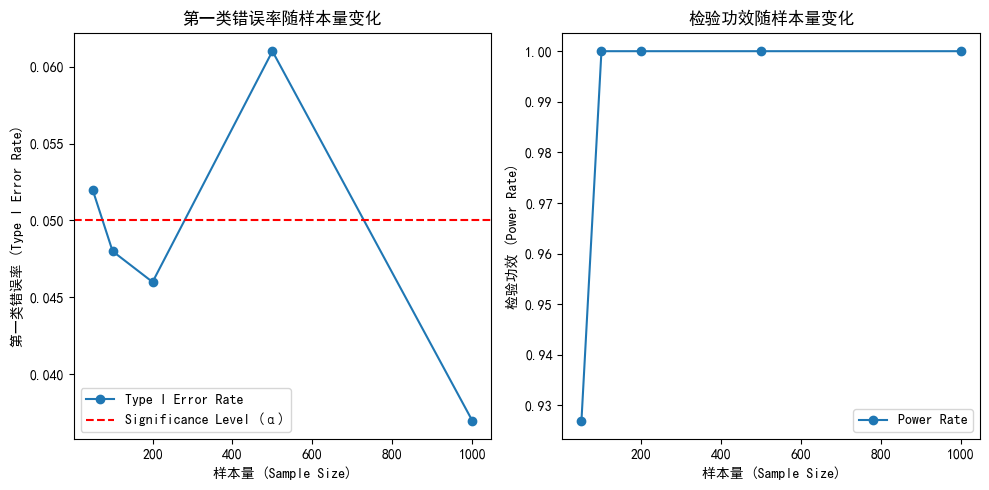

In [17]:
# 创建画布
plt.figure(figsize=(10, 5))

# 绘制 Type I Error Rate 图
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, type_I_errors, marker='o', label='Type I Error Rate')
plt.axhline(y=alpha, color='r', linestyle='--', label='Significance Level (α)')
plt.rcParams['font.family'] ='sans-serif'
plt.rcParams['font.sans-serif'] = 'SimHei'
# 正确显示负号
plt.rcParams['axes.unicode_minus'] = False
plt.xlabel('样本量 (Sample Size)')
plt.ylabel('第一类错误率 (Type I Error Rate)')
plt.title('第一类错误率随样本量变化')
plt.legend()

# 绘制 Power Rate 图
plt.subplot(1, 2, 2)
plt.plot(sample_sizes, power_rates, marker='o', label='Power Rate')
plt.xlabel('样本量 (Sample Size)')
plt.ylabel('检验功效 (Power Rate)')
plt.title('检验功效随样本量变化')
plt.legend()

# 调整布局并显示
plt.tight_layout()
plt.show()

c:\Users\lenovo\miniconda\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\lenovo\miniconda\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\lenovo\miniconda\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\lenovo\miniconda\lib\site-packages\sklearn\preprocessing\_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
c:\Users\lenovo\miniconda\lib\site-packages\sklearn\preprocessing\_d

Scenario 1 - Type I Error Rates:
Ours (single): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Liu: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
KCI: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Scenario 2 - Power:
Ours (single): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Liu: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
KCI: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


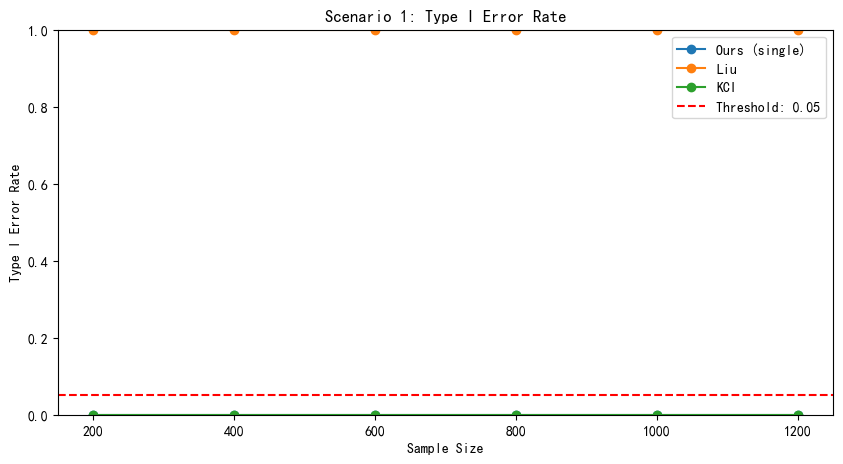

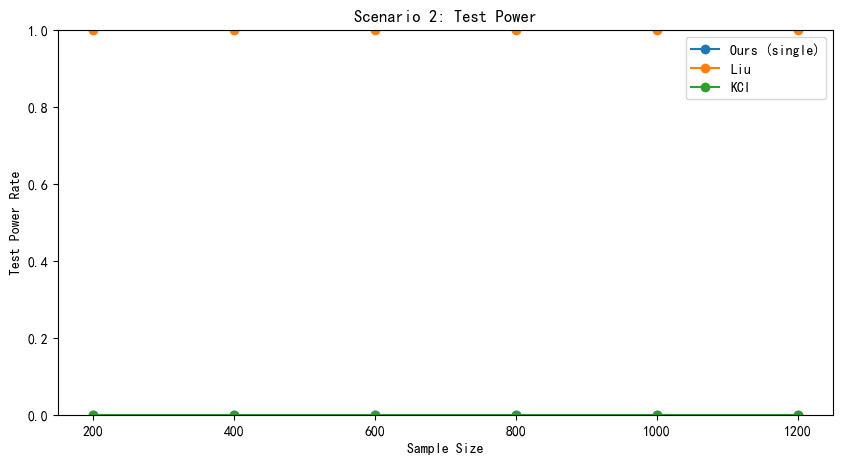

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import norm, f
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load Lalonde dataset (assumes user has downloaded 'lalonde.csv')
data = pd.read_csv('nsw_dw.csv')

# Data extraction
X = data['treat'].values  # Treatment
Y = data['re78'].values   # Outcome
W = data['age'].values    # Proxy variable (age as proxy)

# Data preprocessing
scaler = StandardScaler()
Y = scaler.fit_transform(Y.reshape(-1, 1)).flatten()
W = scaler.fit_transform(W.reshape(-1, 1)).flatten()

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X.reshape(-1, 1)).flatten()
Y = imputer.fit_transform(Y.reshape(-1, 1)).flatten()
W = imputer.fit_transform(W.reshape(-1, 1)).flatten()

# Experimental scenarios
# Scenario 1: No W→Y effect
Y_scenario1 = Y.copy()

# Scenario 2: Simulated W→Y effect
gamma_W = 0.7
Y_scenario2 = Y + gamma_W * W

# Method implementations
def pmcr_test(X, Y, W):
    cov_XW = np.cov(X, W)[0, 1]
    cov_WY = np.cov(W, Y)[0, 1]
    test_stat = np.abs(cov_XW * cov_WY) / np.var(W)
    p_value = 2 * (1 - norm.cdf(np.abs(test_stat)))
    return test_stat, p_value

def liu2023_test(X, Y, W, n_bins=10):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal')
    X_discrete = discretizer.fit_transform(X.reshape(-1, 1)).flatten()
    W_discrete = discretizer.fit_transform(W.reshape(-1, 1)).flatten()
    Y_discrete = discretizer.fit_transform(Y.reshape(-1, 1)).flatten()
    
    model = LinearRegression()
    model.fit(np.column_stack((X_discrete, W_discrete)), Y_discrete)
    residuals = Y_discrete - model.predict(np.column_stack((X_discrete, W_discrete)))
    test_stat = np.sum(residuals ** 2) / np.var(Y_discrete)
    p_value = 1 - f.cdf(test_stat, len(X) - 3, len(X) - 1)
    return test_stat, p_value

def miao2023_test(X, Y, W):
    def h_param(w, y, params):
        return params[0] + params[1] * w
    
    def loss(params):
        h_values = h_param(W, Y, params)
        discrepancy = np.mean((Y - h_values) ** 2)
        return discrepancy
    
    initial_params = [0.0, 0.0]
    result = minimize(loss, initial_params, method='BFGS')
    test_stat = result.fun
    p_value = 1 - norm.cdf(test_stat / np.std(Y))
    return test_stat, p_value

# Methods dictionary
methods = {
    'Ours (single)': miao2023_test,
    'Liu': liu2023_test,
    'KCI': pmcr_test
}

# Evaluation settings
n_replications = 100
alpha = 0.05
sample_sizes = [200, 400, 600, 800, 1000, 1200]

def evaluate_method(method, X, Y, W, sample_sizes):
    results = []
    for size in sample_sizes:
        rejections = 0
        for _ in range(n_replications):
            idx = np.random.choice(len(X), size, replace=True)
            X_rep, Y_rep, W_rep = X[idx], Y[idx], W[idx]
            _, p_value = method(X_rep, Y_rep, W_rep)
            if p_value < alpha:
                rejections += 1
        rate = rejections / n_replications
        results.append(rate)
    return results

# Scenario 1: Type I error rate
type_I_errors = {}
for name, method in methods.items():
    type_I_errors[name] = evaluate_method(method, X, Y_scenario1, W, sample_sizes)

# Scenario 2: Power
powers = {}
for name, method in methods.items():
    powers[name] = evaluate_method(method, X, Y_scenario2, W, sample_sizes)

# Plotting
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# Type I error rate plot
plt.figure(figsize=(10, 5))
for name in methods:
    plt.plot(sample_sizes, type_I_errors[name], label=name, marker='o')
plt.axhline(y=0.05, color='r', linestyle='--', label='Threshold: 0.05')
plt.title('Scenario 1: Type I Error Rate')
plt.xlabel('Sample Size')
plt.ylabel('Type I Error Rate')
plt.ylim(0, 1.0)
plt.legend()
plt.savefig('type_I_error.png')

# Power plot
plt.figure(figsize=(10, 5))
for name in methods:
    plt.plot(sample_sizes, powers[name], label=name, marker='o')
plt.title('Scenario 2: Test Power')
plt.xlabel('Sample Size')
plt.ylabel('Test Power Rate')
plt.ylim(0, 1.0)
plt.legend()
plt.savefig('power.png')

# Output results
print("Scenario 1 - Type I Error Rates:")
for name in methods:
    print(f"{name}: {type_I_errors[name]}")

print("\nScenario 2 - Power:")
for name in methods:
    print(f"{name}: {powers[name]}")